In [109]:
import pandas as pd
import requests
import yfinance as yf
import numpy as np
import time
from tqdm import tqdm
import psycopg2
from datetime import datetime, timedelta
DB_HOST = 'localhost'
DB_NAME = 'tw'
DB_USER = 'mini'
DB_PASS = 'buddyrich134'
def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn


conn = get_db_connection()
cursor = conn.cursor()
uri_pe = "https://www.twse.com.tw/rwd/zh/afterTrading/BWIBBU_d?date=20240809&selectType=ALL"

res = requests.get(uri_pe)
stock_l = res.json()['data']
stock_list = [i[0] for i in stock_l]

"total len of twse stocks: ", len(stock_list)

('total len of twse stocks: ', 1016)

In [177]:
def backtest_code(code):
    rolling = 5
    cursor.execute(f"SELECT * from public.stock_price where code in ('{code}', '^TWII')")
    conn.commit()
    res = cursor.fetchall()
    df = pd.DataFrame(res)
    df.columns = ['da','code', 'cl', 'hi', 'lo', 'op', 'vol', 'adj']
    pivoted = df.pivot(columns='code', values='cl', index='da')
    pivoted.ffill()
    ret = pivoted.pct_change()
    ret['ret_diff'] = ret[code] - ret['^TWII']
    ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
    ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
    ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])
    ret[code] = (1 + ret[code]).cumprod() - 1
    # ret['^TWII'] = (1 + ret["^TWII"]).cumprod() - 1

    ret['index'] = [i for i in range(len(ret))]
    ret.set_index('index', inplace=True, drop=False)

    # check raise
    ret[f'{code}_lag60'] = ret[code].shift(-20)
    ret['target_60mins'] = ret[f'{code}_lag60'] - ret[code]
    return ret

df = backtest_code("1776.TW")
df

code,1776.TW,^TWII,ret_diff,ret_diff_std,ret_diff_mean,stdize_ret_diff,index,1776.TW_lag60,target_60mins
index,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,0,-0.014085,NaN
1,0.0,-0.001947,0.001947,NaN,NaN,NaN,1,-0.014085,-0.014085
2,0.0,-0.001908,0.001908,NaN,NaN,NaN,2,-0.014085,-0.014085
3,0.0,-0.000760,0.000760,NaN,NaN,NaN,3,-0.016901,-0.016901
4,0.0,0.000789,-0.000789,NaN,NaN,NaN,4,-0.016901,-0.016901
...,...,...,...,...,...,...,...,...,...
2126,0.2,0.000263,0.006829,0.477506,0.041650,0.072924,2126,NaN,NaN
2127,0.2,0.000075,-0.000075,0.347034,0.153512,0.442568,2127,NaN,NaN
2128,0.2,0.000516,-0.000516,0.353197,0.143681,0.408261,2128,NaN,NaN


In [175]:
cursor.execute("SELECT DISTINCT code from public.stock_price;")
conn.commit()
res = cursor.fetchall()
code_list = [i[0] for i in res]


code
1776.TW              0.014085
^TWII               -0.020199
ret_diff             0.001127
ret_diff_std         0.039607
ret_diff_mean        0.110334
stdize_ret_diff      2.757239
index              906.000000
1776.TW_lag60        0.019718
TWII_lag60          -0.016782
target_60mins        0.005634
Name: 906, dtype: float64
code
1776.TW              -0.008451
^TWII                -0.049020
ret_diff              0.000742
ret_diff_std          0.026489
ret_diff_mean         0.064708
stdize_ret_diff       2.414788
index              1568.000000
1776.TW_lag60        -0.016901
TWII_lag60           -0.053117
target_60mins        -0.008451
Name: 1568, dtype: float64


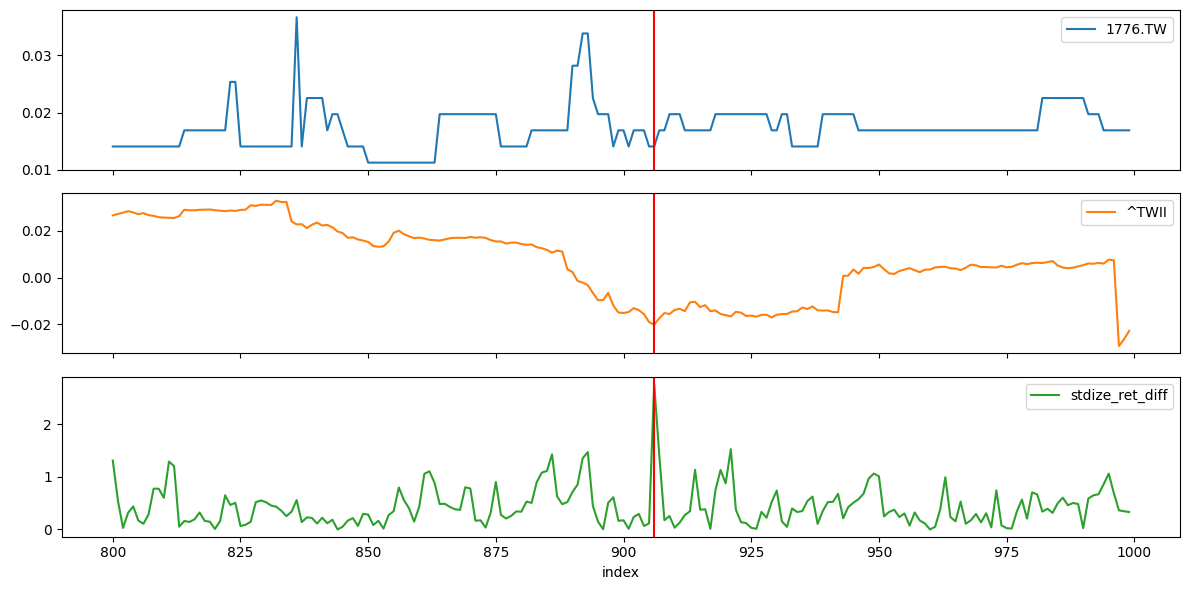

code,1776.TW,^TWII,ret_diff,ret_diff_std,ret_diff_mean,stdize_ret_diff,index,1776.TW_lag60,TWII_lag60,target_60mins,da
index,,,,,,,,,,,
906,0.014085,-0.020199,0.001127,0.039607,0.110334,2.757239,906,0.019718,-0.016782,0.005634,2024-07-19 10:50:00
1568,-0.008451,-0.049020,0.000742,0.026489,0.064708,2.414788,1568,-0.016901,-0.053117,-0.008451,2024-08-20 12:40:00


In [193]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
code = '1776.TW'
rolling = 5
cursor.execute(f"SELECT * from public.stock_price where code in ('{code}', '^TWII')")
conn.commit()
res = cursor.fetchall()
df = pd.DataFrame(res)
df.columns = ['da','code', 'cl', 'hi', 'lo', 'op', 'vol', 'adj']
pivoted = df.pivot(columns='code', values='cl', index='da')
pivoted.ffill()
ret = pivoted.pct_change()
ret['ret_diff'] = ret[code] - ret['^TWII']
ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])
ret[code] = (1 + ret[code]).cumprod() - 1
ret['^TWII'] = (1 + ret["^TWII"]).cumprod() - 1

ret['index'] = [i for i in range(len(ret))]
ret.set_index('index', inplace=True, drop=False)

# check raise
ret[f'{code}_lag60'] = ret[code].shift(-20)
ret[f'TWII_lag60'] = ret["^TWII"].shift(-20)
ret['target_60mins'] = ret[f'{code}_lag60'] - ret[code]
# ret['signal_defineby_prev_ret'] = 
# specific print
start = 0
end = len(ret)
# end = 1000

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 6), sharex=True)
ret.iloc[start:end, [0, 1, 5]].plot(ax=axes, subplots=True, legend=True)
for index, row in ret[ret['stdize_ret_diff'] >= 2].iterrows():  
    print(row)
    if row['index'] >= start and row['index'] <= end:
        for ax in axes:
            ax.axvline(row['index'], color='red')
plt.tight_layout()
plt.show()

# check to long or short
ret['da'] = df['da']
ret[ret['stdize_ret_diff'] >= 2]